# Using WEAVE data with pyKOALA

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import importlib

import warnings
# You may want to comment the following line
warnings.filterwarnings("ignore")

In [2]:
from pykoala import __version__
from pykoala.instruments import weave
from pykoala import cubing

# pyKOALA version
print("pyKOALA version: ", __version__)

pyKOALA version:  0.7.0+0.gf4032b4.dirty


## Load the science data

In [3]:
filename = f"../tests/weave/single_3042890.fit"
rss = weave.weave_rss(filename)
print(f"File {filename} corresponds to object {rss.info['name']}")


Targets in ../tests/weave/single_3042890.fit:
 WA_J024019.19+321544.10 (600 fibres)
centre [40.07995639 32.26229091]
ra 40.0299736 40.1299177
dec 32.219895 32.3046116
File ../tests/weave/single_3042890.fit corresponds to object WA_J024019.19+321544.10


## Registration

### Image Cross-correlation

The most sofisticated method to perform the registration of extended sources included in pyKOALA is based on the cross-correlation of two images.

from koala.register.registration import register_crosscorr

figures = register_crosscorr(sci_rss, plot=True, quick_cube_pix_size=1.)
for fig in figures:
    plt.show(plt.figure(fig))

### Centroid finding

A simple approach to find the offset between the different RSS is to find the center of light of the images (assuming that they contain the same sources).

from koala.register.registration import register_centroid

figures = register_centroid(sci_rss, plot=True, quick_cube_pix_size=0.2,
                            centroider='gauss',
                            #subbox=[[150, 200], [20, 100]]
                           )

for fig in figures:
    plt.show(plt.figure(fig))

### Manual

Alternatively, it is also possible to provide a manual offset for the input RSS frames

For interpolating RSS data into a 3D datacube we will make use of the function *build_cube*. This method requires as input:
- A list of RSS objects. 
- The desired dimensions of the cube expressed as a 2-element tuple, corresponding to (ra, dec) in arcseconds.
- The pixel size of the cube in arcseconds.
- A list containing the ADR correction for every RSS (it can contain None) in the form: [(ADR_ra_1, ADR_dec_1), (ADR_ra_2, ADR_dec_2), (None, None)].
- Additional information to be included in *cube_info*

In [14]:
datacube_shape = (rss.wavelength.size, 40, 60)
ref_position = (rss.wavelength[0], np.mean(rss.info['fib_ra']), np.mean(rss.info['fib_dec']))  # (deg, deg)
spatial_pixel_size = 1.0 / 3600  # (deg)
spectral_pixel_size = rss.wavelength[1] - rss.wavelength[0]  # (angstrom)

print(f"Creating a WCS with\n position: {ref_position}\n Spatial pixel size: {spatial_pixel_size}\n Spectral pixel size: {spectral_pixel_size}")

wcs = cubing.build_wcs(datacube_shape=datacube_shape,
                reference_position=ref_position,
                spatial_pix_size=spatial_pixel_size,
                spectra_pix_size=spectral_pixel_size,
            )

cube = cubing.build_cube(rss_set=[rss],
                  cube_size_arcsec=(90, 90),  # (dec, ra)
                  pixel_size_arcsec=.5,
                  cube_info=dict(name=rss.info['name'].split(' ')[0]))

[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (ra=90, dec=90) arcsec --> (180, 180) pixels (0=Dec, 1=Ra)
[Cubing] Smoothing kernel scale: 4 (pixels)


## Sky substraction

In [20]:
import pykoala.corrections.sky as sky

skymodel = sky.SkyFromObject(cube, bckgr_estimator='mad', source_mask_nsigma=3, remove_cont=False)
skycorrection = sky.SkySubsCorrection(skymodel)
cube, _ = skycorrection.apply(cube)

[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction


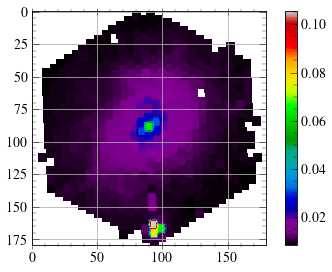

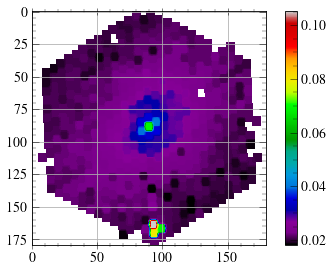

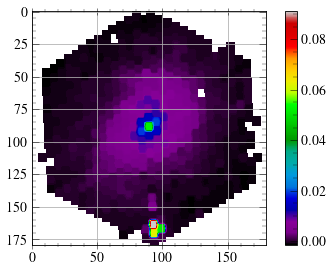

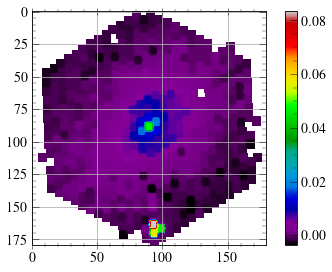

In [28]:
plt.figure()
plt.imshow(np.nanmedian(cube.intensity, axis=0), cmap='nipy_spectral')
plt.colorbar()

plt.figure()
plt.imshow(np.nanmean(cube.intensity, axis=0), cmap='nipy_spectral')
plt.colorbar()

plt.figure()
plt.imshow(np.nanmedian(cube.intensity_corrected, axis=0), cmap='nipy_spectral')
plt.colorbar()

plt.figure()
plt.imshow(np.nanmean(cube.intensity_corrected, axis=0), cmap='nipy_spectral')
plt.colorbar()


(-0.005, 0.1)

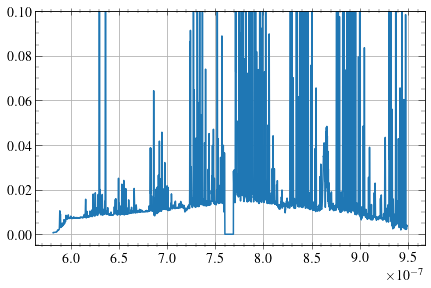

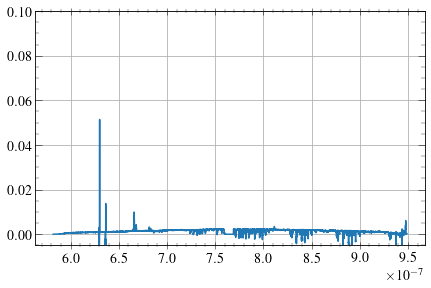

In [34]:
plt.figure()
plt.plot(cube.wavelength, np.nanmean(cube.intensity, axis=(1,2)))
plt.ylim(-.005, .1)

plt.figure()
plt.plot(cube.wavelength, np.nanmean(cube.intensity_corrected, axis=(1,2)))
plt.ylim(-.005, .1)

ValueError: x, y, and format string must not be None

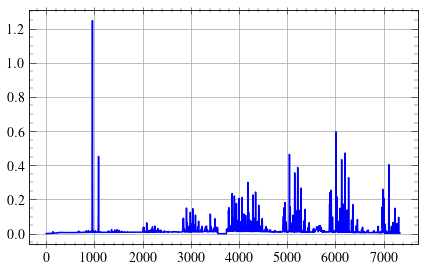

In [38]:
plt.figure()
plt.plot(skymodel.bckgr, 'b-')
plt.plot(skymodel.continuum)


In [45]:
skymodel.wavelength

<SpectralCoord [5.8200e-07, 5.8205e-07, 5.8210e-07, ..., 9.4890e-07, 9.4895e-07,
   9.4900e-07] m>